In [1]:
# !pip install torchtext==0.5
# !python -m spacy download en
# !python -m spacy download de

In [2]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# loading spacy models
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [5]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

In [6]:
# fields to process data
SRC = Field(tokenize=tokenize_de,
           init_token='<sos>',
           eos_token='<eos>',
           lower=True)
TRG = Field(tokenize=tokenize_en,
           init_token='<sos>',
           eos_token='<eos>',
           lower=True)

In [7]:
# loading data
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                   fields=(SRC, TRG))

In [8]:
# print a sample
print(vars(train_data[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [9]:
# building our vocabulary
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# data loaders
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
(train_data, valid_data, test_data),
batch_size = BATCH_SIZE,
device=device)

# Building the Seq2Seq Model
### Encoder

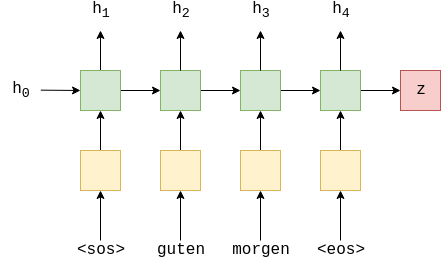

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src, batch size, emb_dim]
        
        output, hidden = self.rnn(embedded)
        #output = [seq len, batch size, hid_dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        return hidden

### Decoder
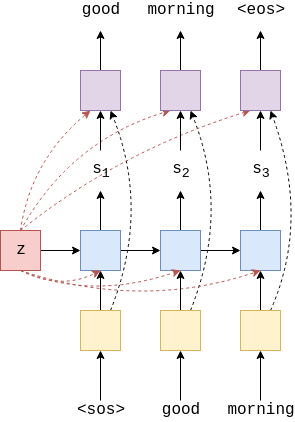

In [13]:
class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim+hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim+hid_dim*2, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, context):
        #input = [batch size] -> one token
        #hidden = [n layers * n directions, batch size, hid_dim]
        #context = [n layers * n directions, batch size, hid_dim]
        
        #n layers and n directions = 1:
        #hidden = [1, batch size, hid_dim]
        #context = [1, batch size, hid_dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb_dim]
        
        emb_con = torch.cat((context, embedded), dim=2)
        #emb_con = [1, batch size, emb_dim+hid_dim]
        
        output, hidden = self.rnn(emb_con, hidden)
        #output = [1, batch size, hid dim] -> seq len = 1
        #hidden = [1, batch size, hid dim] -> n layers and directions = 1
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0),
                           context.squeeze(0)), dim=1)
        #output = [batch size, hid_dim * 2 + emb_dim]
        
        prediction = self.fc_out(output)
        #output = [batch size, out_dim]
        
        return prediction, hidden

### Seq2Seq
- the output tensor is created to hold all predictions
- the source sequence X is fed into the encoder to receive a context vector
- the initial decoder hidden state is set to be the context vector, s0=z=ht
- we use batch \<sos> tokens as the first input y1
- then we decide within a loop:
 - insert the input token y1, previous hidden state, st-1 and context vector z into the encoder
 - receive a prediction y_pred(t+1) and a new hidden state S<sub>t</sub>
 - then we deicde to use teacher forcing or not

In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        
        assert encoder.hid_dim == decoder.hid_dim,\
            "Hidden dimensions of encoder and decoder must be the same!!"
        
    def forward(self, src, trg, teach_forcing_ratio=0.5):
        #src = [seq len, batch size]
        #trg = [seq len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.out_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #context is also used as the initial hidden state
        context = self.encoder(src)
        hidden = context
        
        #a batch of <sos> as input to the decoder
        input = trg[0, :]
        
        for t in range(1, trg_len):
            #insert the input token embeddings, prev hidden, context
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            
            #using teach forcing
            teach_force = random.random() < teach_forcing_ratio
            
            #the highest predicted token in our prediction
            top1 = output.argmax(1)
            
            input = trg[t] if teach_force else top1
        return outputs

### Training the Seq2Seq model 

In [34]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [35]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,220,037 trainable parameters


In [37]:
optimizer = optim.Adam(model.parameters())

In [38]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [39]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        #flattening the output and target + ignoring the <sos>
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [40]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 46s
	Train Loss: 5.059 | Train PPL: 157.373
	 Val. Loss: 5.137 |  Val. PPL: 170.168
Epoch: 02 | Time: 0m 45s
	Train Loss: 4.367 | Train PPL:  78.838
	 Val. Loss: 5.026 |  Val. PPL: 152.332
Epoch: 03 | Time: 0m 46s
	Train Loss: 4.079 | Train PPL:  59.070
	 Val. Loss: 4.982 |  Val. PPL: 145.820
Epoch: 04 | Time: 0m 46s
	Train Loss: 3.773 | Train PPL:  43.515
	 Val. Loss: 4.436 |  Val. PPL:  84.471
Epoch: 05 | Time: 0m 43s
	Train Loss: 3.432 | Train PPL:  30.945
	 Val. Loss: 4.052 |  Val. PPL:  57.498
Epoch: 06 | Time: 0m 46s
	Train Loss: 3.137 | Train PPL:  23.045
	 Val. Loss: 3.892 |  Val. PPL:  49.012
Epoch: 07 | Time: 0m 45s
	Train Loss: 2.903 | Train PPL:  18.223
	 Val. Loss: 3.686 |  Val. PPL:  39.893
Epoch: 08 | Time: 0m 46s
	Train Loss: 2.618 | Train PPL:  13.708
	 Val. Loss: 3.710 |  Val. PPL:  40.872
Epoch: 09 | Time: 0m 45s
	Train Loss: 2.413 | Train PPL:  11.166
	 Val. Loss: 3.639 |  Val. PPL:  38.036
Epoch: 10 | Time: 0m 46s
	Train Loss: 2.215 | Train PPL

In [43]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.638 | Test PPL:  38.033 |
